In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import KFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score


In [4]:
# Set random seed for reproducibility
np.random.seed(42)


In [5]:
# Load the California Housing dataset
housing = fetch_california_housing()
X = pd.DataFrame(housing.data, columns=housing.feature_names)
y = housing.target

In [6]:
print("Dataset shape:", X.shape)
print("Feature names:", housing.feature_names)
print("Target variable: Median house value (in $100,000s)")


Dataset shape: (20640, 8)
Feature names: ['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup', 'Latitude', 'Longitude']
Target variable: Median house value (in $100,000s)


In [7]:
# Let's have a quick look at the data
print("\nFeature statistics:")
print(X.describe().round(2))


Feature statistics:
         MedInc  HouseAge  AveRooms  AveBedrms  Population  AveOccup  \
count  20640.00  20640.00  20640.00   20640.00    20640.00  20640.00   
mean       3.87     28.64      5.43       1.10     1425.48      3.07   
std        1.90     12.59      2.47       0.47     1132.46     10.39   
min        0.50      1.00      0.85       0.33        3.00      0.69   
25%        2.56     18.00      4.44       1.01      787.00      2.43   
50%        3.53     29.00      5.23       1.05     1166.00      2.82   
75%        4.74     37.00      6.05       1.10     1725.00      3.28   
max       15.00     52.00    141.91      34.07    35682.00   1243.33   

       Latitude  Longitude  
count  20640.00   20640.00  
mean      35.63    -119.57  
std        2.14       2.00  
min       32.54    -124.35  
25%       33.93    -121.80  
50%       34.26    -118.49  
75%       37.71    -118.01  
max       41.95    -114.31  


In [8]:
# Feature preprocessing: Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [9]:
# 1. Basic K-fold cross-validation
def kfold_cv_basic(X, y, model, n_splits=5):
    """
    Perform basic k-fold cross-validation and return scores.
    """
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    fold_rmse = []
    fold_r2 = []

    print(f"\nPerforming {n_splits}-fold cross-validation...")

    for fold, (train_idx, test_idx) in enumerate(kf.split(X)):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]

        # Train the model
        model.fit(X_train, y_train)

        # Make predictions
        y_pred = model.predict(X_test)

        # Calculate metrics
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        r2 = r2_score(y_test, y_pred)

        fold_rmse.append(rmse)
        fold_r2.append(r2)

        print(f"Fold {fold+1}: RMSE = {rmse:.4f}, R² = {r2:.4f}")

    # Calculate average scores
    print(f"\nAverage RMSE: {np.mean(fold_rmse):.4f} (±{np.std(fold_rmse):.4f})")
    print(f"Average R²: {np.mean(fold_r2):.4f} (±{np.std(fold_r2):.4f})")

    return fold_rmse, fold_r2

In [10]:
# Let's try with a simple linear regression model
lr_model = LinearRegression()
lr_rmse, lr_r2 = kfold_cv_basic(X_scaled, y, lr_model, n_splits=5)


Performing 5-fold cross-validation...
Fold 1: RMSE = 0.7456, R² = 0.5758
Fold 2: RMSE = 0.7264, R² = 0.6137
Fold 3: RMSE = 0.7136, R² = 0.6086
Fold 4: RMSE = 0.7105, R² = 0.6213
Fold 5: RMSE = 0.7451, R² = 0.5875

Average RMSE: 0.7283 (±0.0149)
Average R²: 0.6014 (±0.0170)


In [11]:
# 2. Comparing multiple models with K-fold
def compare_models_kfold(X, y, models, n_splits=5):
    """
    Compare multiple models using k-fold cross-validation.
    """
    results = {}

    for name, model in models.items():
        print(f"\n{'-'*50}")
        print(f"Evaluating: {name}")

        # Create KFold object
        kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

        # Use scikit-learn's cross_val_score for convenience
        rmse_scores = -cross_val_score(model, X, y,
                                     scoring='neg_root_mean_squared_error',
                                     cv=kf, n_jobs=-1)

        r2_scores = cross_val_score(model, X, y,
                                   scoring='r2',
                                   cv=kf, n_jobs=-1)

        # Store results
        results[name] = {
            'rmse': rmse_scores,
            'r2': r2_scores
        }

        # Print results
        print(f"RMSE: {np.mean(rmse_scores):.4f} (±{np.std(rmse_scores):.4f})")
        print(f"R²: {np.mean(r2_scores):.4f} (±{np.std(r2_scores):.4f})")

    return results

In [12]:
# Define models to compare
models = {
    'Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge(alpha=1.0),
    'Lasso Regression': Lasso(alpha=0.1),
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42)
}

In [13]:
# Compare models
results = compare_models_kfold(X_scaled, y, models, n_splits=5)


--------------------------------------------------
Evaluating: Linear Regression
RMSE: 0.7283 (±0.0149)
R²: 0.6014 (±0.0170)

--------------------------------------------------
Evaluating: Ridge Regression
RMSE: 0.7282 (±0.0149)
R²: 0.6014 (±0.0170)

--------------------------------------------------
Evaluating: Lasso Regression
RMSE: 0.8211 (±0.0084)
R²: 0.4934 (±0.0104)

--------------------------------------------------
Evaluating: Random Forest
RMSE: 0.5034 (±0.0086)
R²: 0.8095 (±0.0067)


In [14]:
# 3. Visualize cross-validation results
def plot_cv_results(results):
    """
    Plot the cross-validation results for easy comparison.
    """
    # Setup plot
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))

    # Models and corresponding colors
    models = list(results.keys())
    colors = ['blue', 'green', 'red', 'purple']

    # RMSE plot (lower is better)
    ax = axes[0]
    for i, model in enumerate(models):
        rmse_data = results[model]['rmse']
        ax.bar(i, np.mean(rmse_data), yerr=np.std(rmse_data),
               capsize=10, color=colors[i], alpha=0.7,
               label=f"{model} ({np.mean(rmse_data):.4f})")

    ax.set_xticks(range(len(models)))
    ax.set_xticklabels(models, rotation=45, ha='right')
    ax.set_ylabel('RMSE (lower is better)')
    ax.set_title('Cross-Validation RMSE by Model')
    ax.grid(axis='y', linestyle='--', alpha=0.7)

    # R² plot (higher is better)
    ax = axes[1]
    for i, model in enumerate(models):
        r2_data = results[model]['r2']
        ax.bar(i, np.mean(r2_data), yerr=np.std(r2_data),
               capsize=10, color=colors[i], alpha=0.7,
               label=f"{model} ({np.mean(r2_data):.4f})")

    ax.set_xticks(range(len(models)))
    ax.set_xticklabels(models, rotation=45, ha='right')
    ax.set_ylabel('R² Score (higher is better)')
    ax.set_title('Cross-Validation R² by Model')
    ax.grid(axis='y', linestyle='--', alpha=0.7)

    plt.tight_layout()
    plt.show()

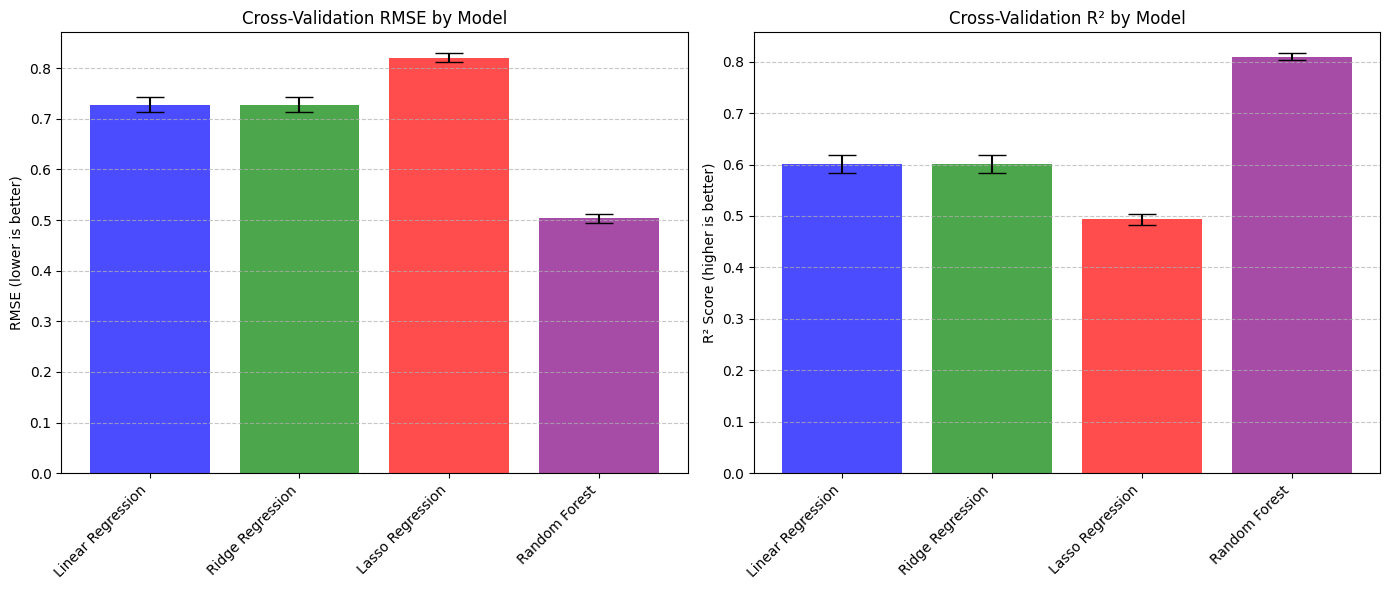

In [15]:
# Plot the results
plot_cv_results(results)

In [16]:
# 4. Hyperparameter tuning with K-fold CV
from sklearn.model_selection import GridSearchCV

# Let's optimize the Random Forest model
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10]
}


In [17]:
# Create the grid search object
grid_search = GridSearchCV(
    estimator=RandomForestRegressor(random_state=42),
    param_grid=param_grid,
    cv=KFold(n_splits=5, shuffle=True, random_state=42),
    scoring='neg_root_mean_squared_error',
    n_jobs=-1,
    verbose=1
)

In [18]:
# Perform grid search
print("\nPerforming grid search for Random Forest hyperparameters...")
grid_search.fit(X_scaled, y)

# Print results
print("\nBest parameters:", grid_search.best_params_)
print("Best RMSE: {:.4f}".format(-grid_search.best_score_))


Performing grid search for Random Forest hyperparameters...
Fitting 5 folds for each of 36 candidates, totalling 180 fits

Best parameters: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 200}
Best RMSE: 0.5009


In [19]:

# Get the best model
best_rf = grid_search.best_estimator_

In [20]:
# Feature importance
feature_importance = pd.DataFrame({
    'Feature': housing.feature_names,
    'Importance': best_rf.feature_importances_
}).sort_values('Importance', ascending=False)

print("\nFeature Importance:")
print(feature_importance)


Feature Importance:
      Feature  Importance
0      MedInc    0.519887
5    AveOccup    0.136376
6    Latitude    0.093475
7   Longitude    0.092470
1    HouseAge    0.052702
2    AveRooms    0.044489
4  Population    0.031330
3   AveBedrms    0.029271


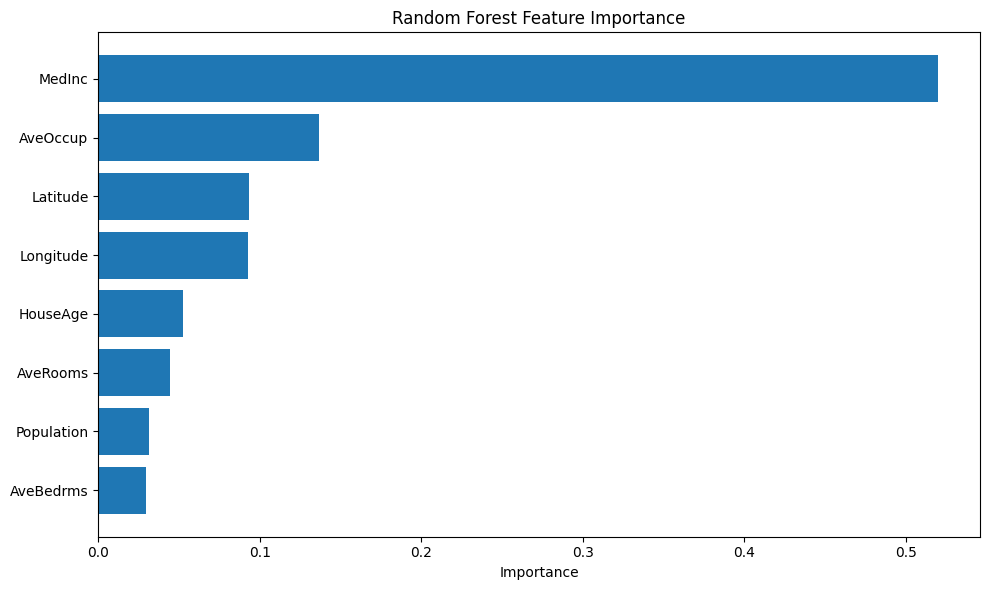

In [21]:
# Plot feature importance
plt.figure(figsize=(10, 6))
plt.barh(feature_importance['Feature'], feature_importance['Importance'])
plt.xlabel('Importance')
plt.title('Random Forest Feature Importance')
plt.gca().invert_yaxis()  # To display the most important feature at the top
plt.tight_layout()
plt.show()

In [22]:
# A function to demonstrate how to use the results in practice
def train_final_model(X, y, best_model):
    """
    Train the final model on the entire dataset after cross-validation.
    """
    print("\nTraining final model on the entire dataset...")

    # Train on the entire dataset
    best_model.fit(X, y)

    # Make predictions on the training data (for demonstration)
    y_pred = best_model.predict(X)

    # Calculate final metrics
    rmse = np.sqrt(mean_squared_error(y, y_pred))
    r2 = r2_score(y, y_pred)

    print(f"Final model RMSE on training data: {rmse:.4f}")
    print(f"Final model R² on training data: {r2:.4f}")

    return best_model

In [23]:
# Train the final model
final_model = train_final_model(X_scaled, y, best_rf)

print("\nK-fold cross-validation workflow complete!")


Training final model on the entire dataset...
Final model RMSE on training data: 0.1830
Final model R² on training data: 0.9748

K-fold cross-validation workflow complete!
